# Test of range data lags for the observed oscillations

Following tests are scripted for comprehensive characterization
- convergence to reference orbit with zero lags
- impact of a uniform lag in the range data
- impact of light-time lags, i.e., range rate and light time
- impact of light-time lags times a scale factor


In [1]:
from astropy import units as u
sampling_interval = 1*u.hour
tracking_period = 5*u.day

In [2]:
from astropy import constants as const
from astropy import visualization
from astropy.coordinates import solar_system_ephemeris

from poliastro.util import norm
from poliastro.twobody.sampling import EpochsArray

import numpy as np
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sim.stations import dss25, dss34
from sim.tracking import Tracking
from sim.util import orbit_from_horizons, make_epochs, find_rates
from sim.util import describe_orbit, describe_trajectory, plot_residual, plot_swings
from sim.fitorbit import OrbitFitter

def plots(epochs, residual, title, ylab):
    plot_residual(epochs, residual, title, 'Residual ' + ylab)
    try:
        e, s = plot_swings(epochs, residual, None, 'Residual swings ' + ylab)
        #print(s)
    except ValueError:
        # no swings identified
        pass

def fitr(ref_orbit, ref_stations, epochs, sim_meas, title, _trace=False):
    fitter = OrbitFitter(ref_orbit, ref_stations, trace=_trace)
    fitter.fit_range_data(epochs, sim_meas)
    print(fitter.report())
    print('Time elapsed (hh:mm:ss.ms) {}'.format(fitter.runtime))
    describe_orbit(fitter.orbit)
    plots(epochs, fitter.result.residual, title, 'range (m)')
    rates = find_rates(epochs, fitter.result.residual)
    plots(epochs[1:], rates, None, 'range rate (m/s)')
    return fitter, rates

def reusefitr(fitsolution, epochs, sim_meas, title):
    residual = fitsolution.range_residual(epochs, sim_meas)
    plots(epochs, residual, title, 'range (m)')
    rates = find_rates(epochs, residual)
    plots(epochs[11:], rates[10:], None, 'range rate (m/s)')
    return rates

In [3]:
solar_system_ephemeris.set("de440")
goldstone_end = Tracking.NEAR_GOLDSTONE_END.value

near_goldstone_orbit = orbit_from_horizons("NEAR", goldstone_end)
describe_orbit(near_goldstone_orbit)


::ORBIT::
Plane: Planes.EARTH_EQUATOR
Inclination: 107.97266698121356 deg
Eccentricity: 1.813357091534396
Semilatus rectum: 19437.250829758486 km
Semimajor axix: -8494.322039490264 km
Periapse radius: 6908.917068596319 km , altitude: 530.7804685963192 km


In [4]:
canberra_start = Tracking.NEAR_CANBERRA_START.value
canberra_end = canberra_start + tracking_period
epochs = make_epochs(canberra_start, canberra_end, sampling_interval)
print("Start and end:", epochs[0], epochs[-1], "[", epochs.size, "]")

near_extended_ephem = near_goldstone_orbit.to_ephem(EpochsArray(epochs))
describe_trajectory(near_extended_ephem, dss34)

Start and end: 1998-01-23 09:53:55.600 1998-01-28 08:53:55.600 [ 120 ]

::TRAJECTORY::
Start and end ranges: 99245.7532096098 km 3036239.0077683222 km
Start and end radial speeds: 7.3216176182785535 km / s 6.784349119880077 km / s
Closest: 73145.82143191747 km speed 7.5891622264313146 km / s  at  1998-01-23 09:53:55.600
Deflection: 0.4576006592003391 deg


In [5]:
rdata_ref = []
rlags = []
rlags_full = []
rdata_constrlags = []
rdata_ltlags_full = []
rdata_ltlags = []
rdata_scaledlags = []

scalefactor = 0.1
first_rlag = None

for e in epochs:
    rv = near_extended_ephem.rv(e)
    ref_r, ref_rr, ref_rs = dss34.range_and_rates(rv, e)
    print(e.strftime("%H:%M:%S"),
         ref_r.to_value(u.km),
         ref_rr.to_value(u.m/u.s),
         ref_rs.to_value(u.m/u.s),
         (ref_rr+ref_rs).to_value(u.m/u.s),
         )

    rlag_full = ref_rr*ref_r/const.c
    rlag = (ref_rr+ref_rs)*ref_r/const.c

    if first_rlag is None:
        first_rlag = rlag

    rlags.append(rlag)
    rlags_full.append(rlag_full)

    rdata_ref.append([ref_r])
    rdata_constrlags.append([ref_r - first_rlag])
    rdata_ltlags_full.append([ref_r - rlag_full])
    rdata_ltlags.append([ref_r - rlag])
    rdata_scaledlags.append([ref_r - scalefactor*rlag])

09:53:55 73145.82143191747 7321.617618278554 68.79038110949617 7390.40799938805
10:53:55 99245.7532096098 7187.7369454526515 102.08657772440507 7289.823523177057
11:53:55 124953.15770282669 7100.470021274935 120.15213999260801 7220.622161267543
12:53:55 150407.26865298714 7045.180149880965 125.83416256857925 7171.014312449544
13:53:55 175706.3273609694 7013.212834377098 120.61516993443941 7133.828004311538
14:53:55 200923.61747138412 6998.968415835037 105.8921418109968 7104.860557646034
15:53:55 226115.081514972 6998.227213421146 83.32665523403492 7081.553868655181
16:53:55 251322.7147374973 7007.379229306495 54.90520121159005 7062.284430518085
17:53:55 276576.09410904173 7023.105801442162 22.879163338189827 7045.984964780352
18:53:55 301893.2139723953 7042.287322157354 -10.353411101246321 7031.933911056107
19:53:55 327281.2187505763 7062.02518157836 -42.39282624158386 7019.6323553367765
20:53:55 352737.32525912847 7079.717672930693 -70.98897839406094 7008.728694536632
21:53:55 378250.

17:53:55 2662495.4370598304 6872.765167679641 -0.8483842618025541 6871.916783417839
18:53:55 2687292.436792106 6903.158498496167 -31.424141655725855 6871.734356840441
19:53:55 2712195.580307736 6931.391791461586 -59.83880890382566 6871.55298255776
20:53:55 2737193.511970566 6955.513080107106 -84.14125949782577 6871.371820609281
21:53:55 2762268.322841211 6973.854615035983 -102.66431992920289 6871.1902951067805
22:53:55 2787396.7871512296 6985.1473182299005 -114.13921799008095 6871.00810023982
23:53:55 2812551.9627528093 6988.6073814314495 -117.78219187115074 6870.825189560298
00:53:55 2837705.044099516 6983.989185094649 -113.3474312041555 6870.641753890494
01:53:55 2862827.339612924 6971.601126391596 -101.1429341719566 6870.458192219639
02:53:55 2887892.2376337643 6952.283531735762 -82.00845361507197 6870.2750781206905
03:53:55 2912877.026864835 6927.350403389808 -57.25728111797648 6870.093122271832
04:53:55 2937764.4478836963 6898.499143150008 -28.586012847538935 6869.91313030247
05:5

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 8
    # data points      = 120
    # variables        = 6
    chi-square         = 6.3011e-07
    reduced chi-square = 5.5273e-09
    Akaike info crit   = -2275.78321
    Bayesian info crit = -2259.05826
##  Warning: uncertainties could not be estimated:
    a:     at initial value
    ecc:   at initial value
    inc:   at initial value
    nu:    at initial value
    raan:  at initial value
    argp:  at initial value
[[Variables]]
    a:    -8494322.04 (init = -8494322)
    ecc:   1.81335709 (init = 1.813357)
    inc:   1.88447854 (init = 1.884479)
    nu:   -1.83942476 (init = -1.839425)
    raan:  1.54005925 (init = 1.540059)
    argp:  2.53325839 (init = 2.533258)
Time elapsed (hh:mm:ss.ms) 0:00:04.628610

::ORBIT::
Plane: Planes.EARTH_EQUATOR
Inclination: 107.97266698121356 deg
Eccentricity: 1.813357091534396
Semilatus rectum: 19437250.829758488 m
Semimajor axix: -8494322.039490264 m
Periapse radius: 690

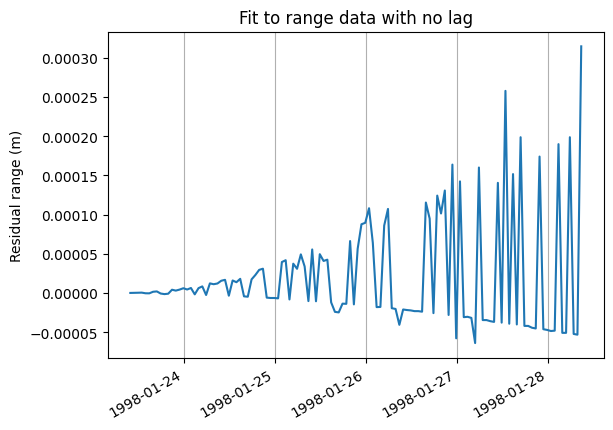

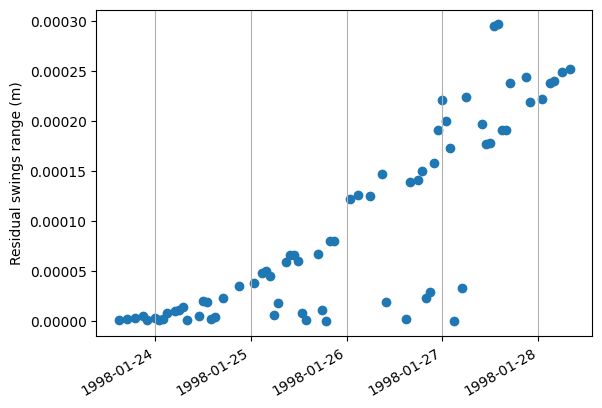

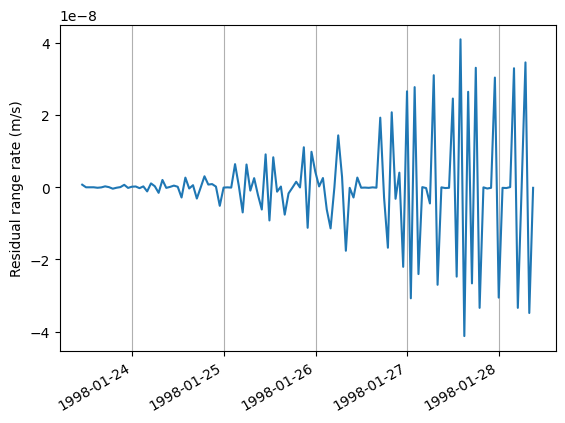

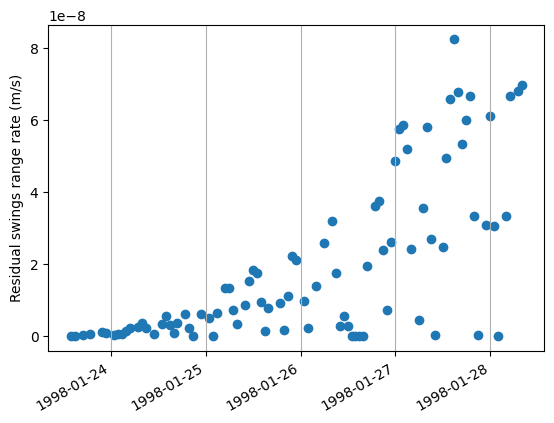

In [6]:
_,_ = fitr(near_goldstone_orbit, [dss34], epochs, rdata_ref, "Fit to range data with no lag")

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 15
    # data points      = 120
    # variables        = 6
    chi-square         = 53838.8592
    reduced chi-square = 472.270695
    Akaike info crit   = 744.751084
    Bayesian info crit = 761.476034
##  Warning: uncertainties could not be estimated:
    a:     at initial value
    ecc:   at initial value
    inc:   at initial value
    nu:    at initial value
    raan:  at initial value
    argp:  at initial value
[[Variables]]
    a:    -8494322.04 (init = -8494322)
    ecc:   1.81335709 (init = 1.813357)
    inc:   1.88447854 (init = 1.884479)
    nu:   -1.83944110 (init = -1.839425)
    raan:  1.54004478 (init = 1.540059)
    argp:  2.53325264 (init = 2.533258)
Time elapsed (hh:mm:ss.ms) 0:00:07.537947

::ORBIT::
Plane: Planes.EARTH_EQUATOR
Inclination: 107.97266698121356 deg
Eccentricity: 1.813357091534396
Semilatus rectum: 19437250.829758488 m
Semimajor axix: -8494322.039490264 m
Periapse radius: 6908

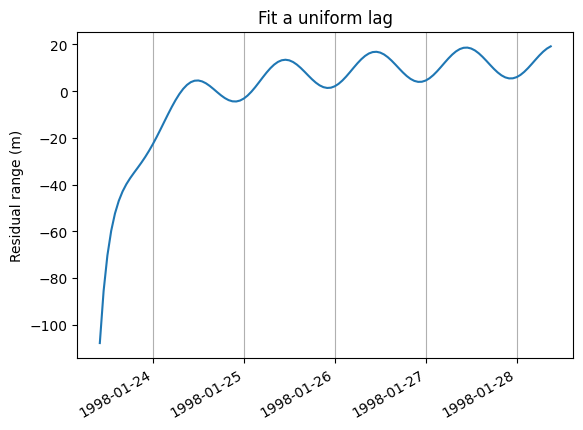

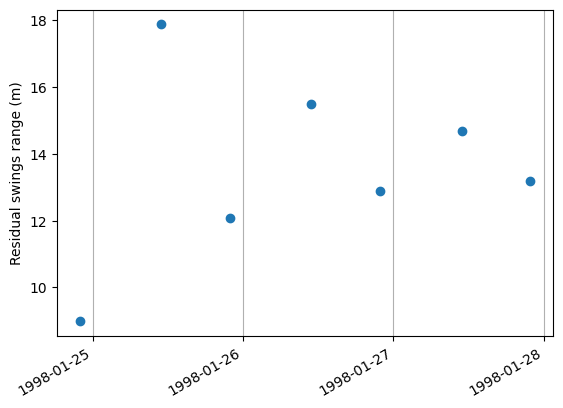

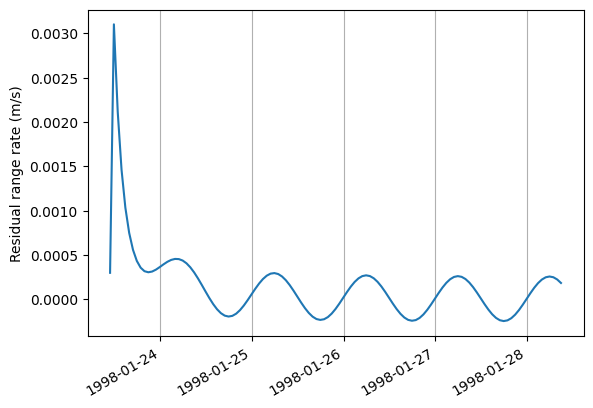

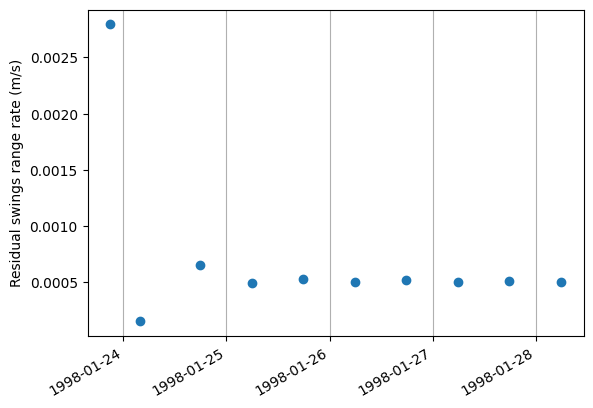

In [7]:
constfitr, const_rates = fitr(near_goldstone_orbit, [dss34], epochs, rdata_constrlags, "Fit a uniform lag")

[15.496765496209264, 12.884404044598341, 14.677244704216719, 13.193594291806221]
[0.000511987956189033, 0.0005029862707791228, 0.0005066309434672196, 0.0005024108233758144]


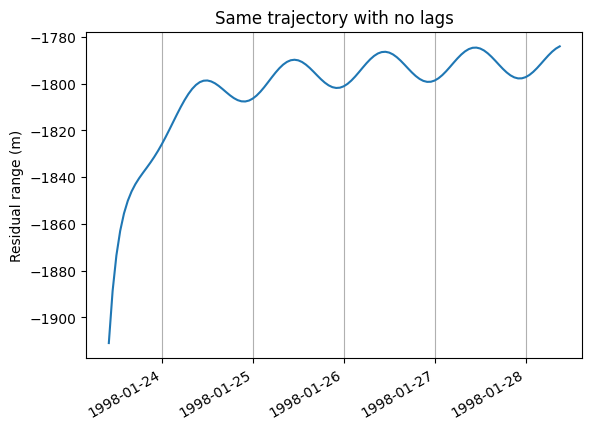

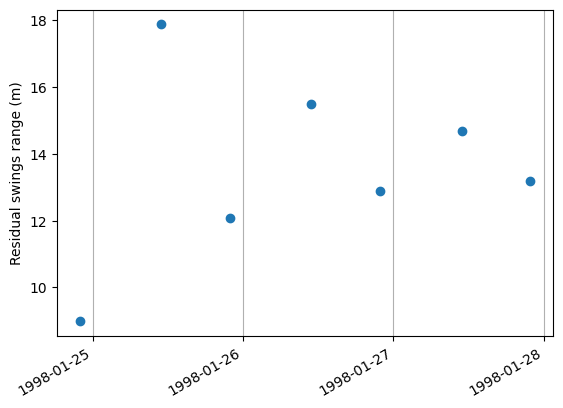

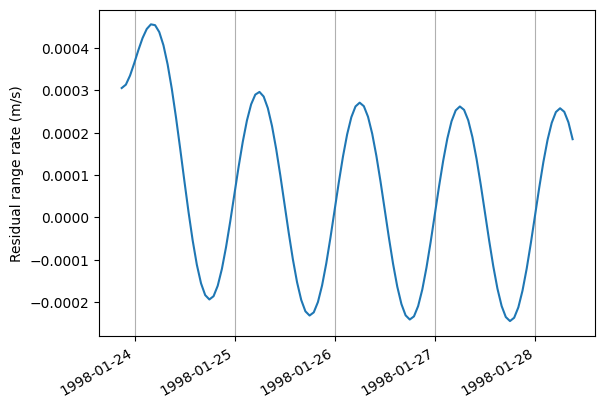

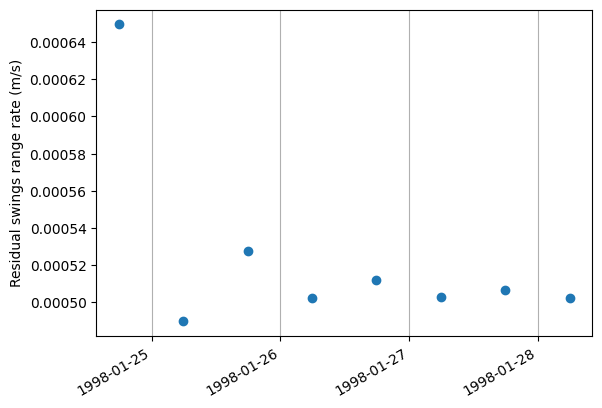

In [8]:
_ = reusefitr(constfitr, epochs, rdata_ref, "Same trajectory with no lags")

[0.002984050564312543, 0.002860916202836017, 0.0029426077122074318, 0.00287251818614688]


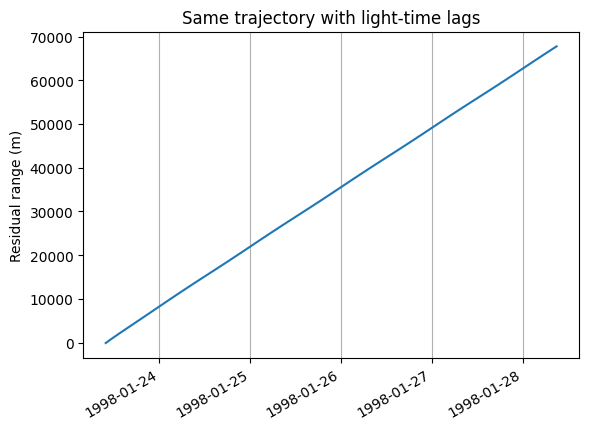

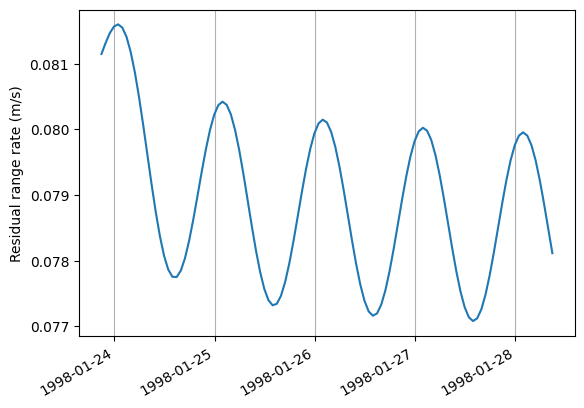

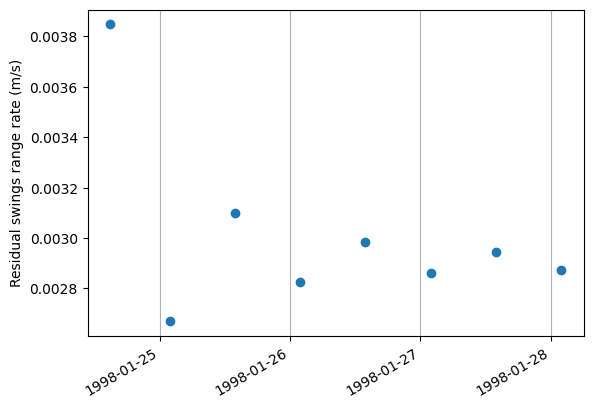

In [9]:
_ = reusefitr(constfitr, epochs, rdata_ltlags, "Same trajectory with light-time lags")

[0.002984050564312543, 0.002860916202836017, 0.0029426077122074318, 0.00287251818614688]


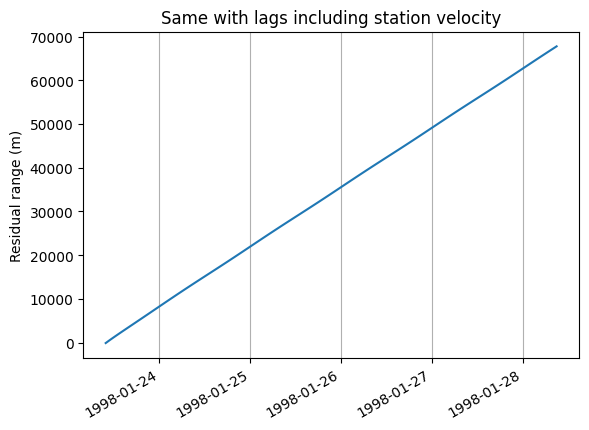

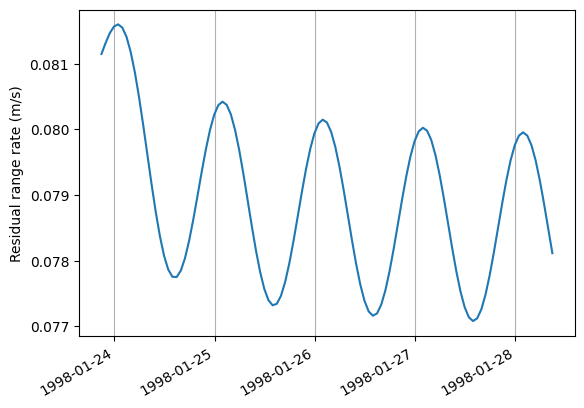

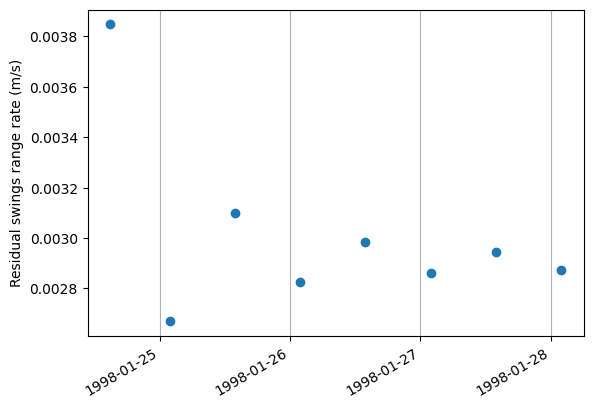

In [10]:
_ = reusefitr(constfitr, epochs, rdata_ltlags, "Same with lags including station velocity")

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 41
    # data points      = 120
    # variables        = 6
    chi-square         = 4.7257e+10
    reduced chi-square = 4.1454e+08
    Akaike info crit   = 2386.96516
    Bayesian info crit = 2403.69011
##  Warning: uncertainties could not be estimated:
    a:     at initial value
    ecc:   at initial value
    inc:   at initial value
[[Variables]]
    a:    -8494322.04 (init = -8494322)
    ecc:   1.81335709 (init = 1.813357)
    inc:   1.88447854 (init = 1.884479)
    nu:   -1.83974671 (init = -1.839425)
    raan:  1.54518682 (init = 1.540059)
    argp:  2.53426695 (init = 2.533258)
Time elapsed (hh:mm:ss.ms) 0:00:19.939993

::ORBIT::
Plane: Planes.EARTH_EQUATOR
Inclination: 107.97266698121356 deg
Eccentricity: 1.813357091534396
Semilatus rectum: 19437250.829758488 m
Semimajor axix: -8494322.039490264 m
Periapse radius: 6908917.068596319 m , altitude: 530780.4685963197 m
[14525.407063774765, 936.45515572279

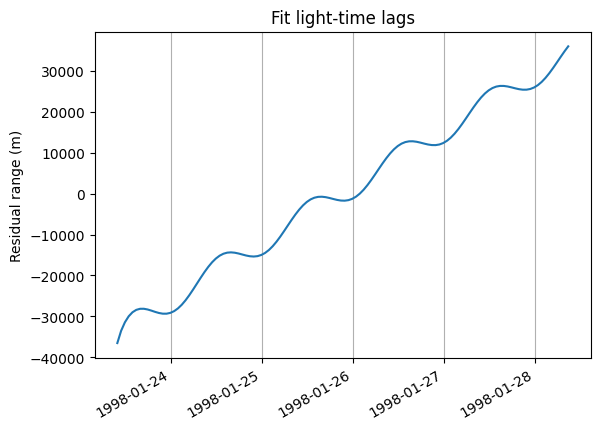

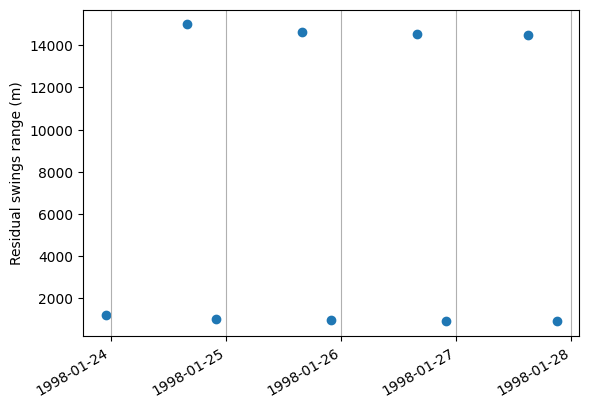

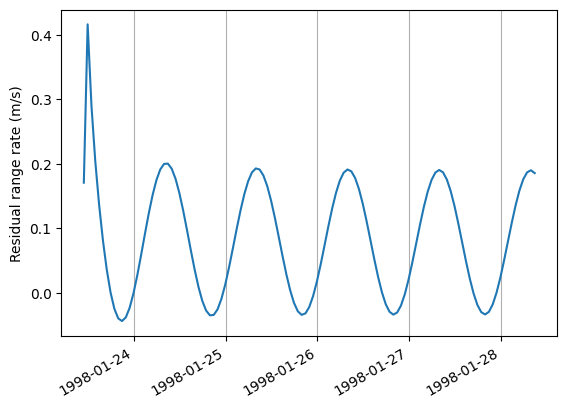

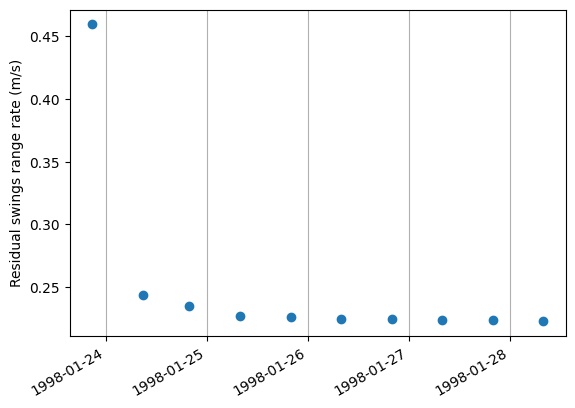

In [11]:
_, ltres_rates = fitr(near_goldstone_orbit, [dss34], epochs, rdata_ltlags, "Fit light-time lags")

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 120
    # variables        = 6
    chi-square         = 4.7253e+08
    reduced chi-square = 4145006.97
    Akaike info crit   = 1834.33461
    Bayesian info crit = 1851.05956
##  Warning: uncertainties could not be estimated:
    a:     at initial value
    ecc:   at initial value
    inc:   at initial value
[[Variables]]
    a:    -8494322.04 (init = -8494322)
    ecc:   1.81335709 (init = 1.813357)
    inc:   1.88447854 (init = 1.884479)
    nu:   -1.83945697 (init = -1.839425)
    raan:  1.54063332 (init = 1.540059)
    argp:  2.53337819 (init = 2.533258)
Time elapsed (hh:mm:ss.ms) 0:00:13.805832

::ORBIT::
Plane: Planes.EARTH_EQUATOR
Inclination: 107.97266698121356 deg
Eccentricity: 1.813357091534396
Semilatus rectum: 19437250.829758488 m
Semimajor axix: -8494322.039490264 m
Periapse radius: 6908917.068596319 m , altitude: 530780.4685963197 m
[1456.7673904821277, 98.142121685668

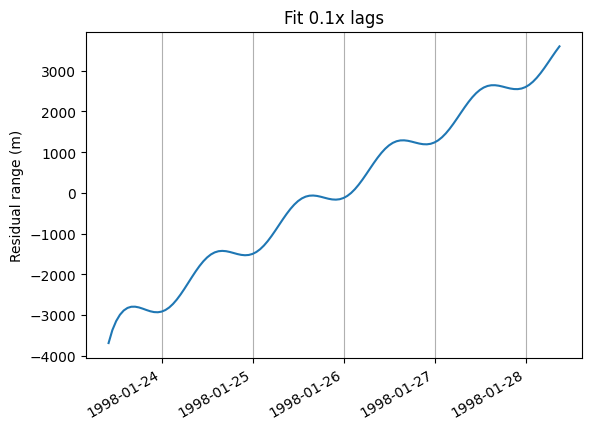

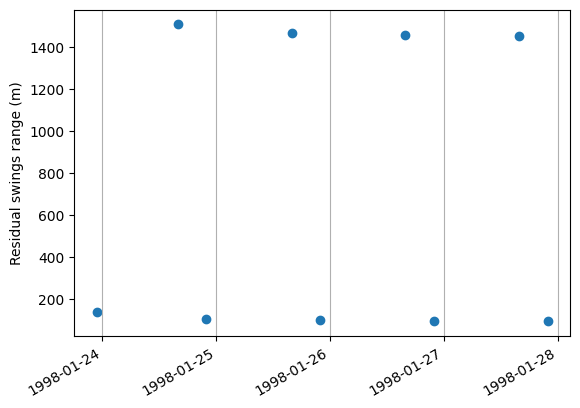

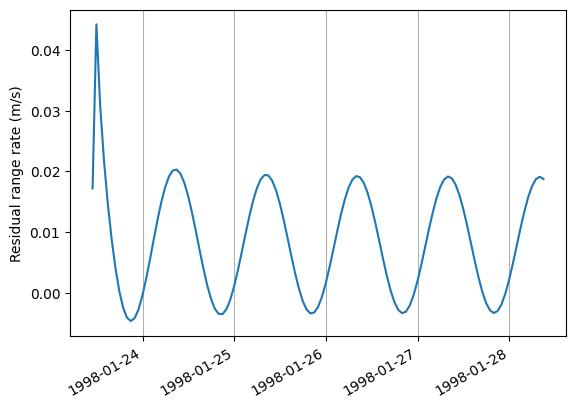

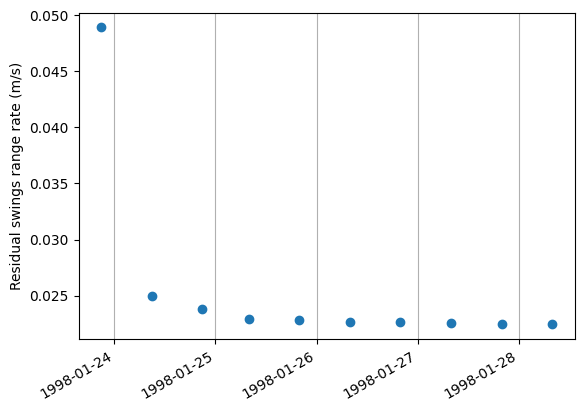

In [12]:
_,_ = fitr(near_goldstone_orbit, [dss34], epochs, rdata_scaledlags, f'Fit {scalefactor}x lags')

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 120
    # variables        = 6
    chi-square         = 4.7208e+10
    reduced chi-square = 4.1410e+08
    Akaike info crit   = 2386.84025
    Bayesian info crit = 2403.56520
##  Warning: uncertainties could not be estimated:
    a:     at initial value
    ecc:   at initial value
    inc:   at initial value
[[Variables]]
    a:    -8494322.04 (init = -8494322)
    ecc:   1.81335709 (init = 1.813357)
    inc:   1.88447854 (init = 1.884479)
    nu:   -1.83974678 (init = -1.839425)
    raan:  1.54606871 (init = 1.540059)
    argp:  2.53442137 (init = 2.533258)
Time elapsed (hh:mm:ss.ms) 0:00:19.942002

::ORBIT::
Plane: Planes.EARTH_EQUATOR
Inclination: 107.97266698121356 deg
Eccentricity: 1.813357091534396
Semilatus rectum: 19437250.829758488 m
Semimajor axix: -8494322.039490264 m
Periapse radius: 6908917.068596319 m , altitude: 530780.4685963197 m
[14462.882870342582, 692.36188847571

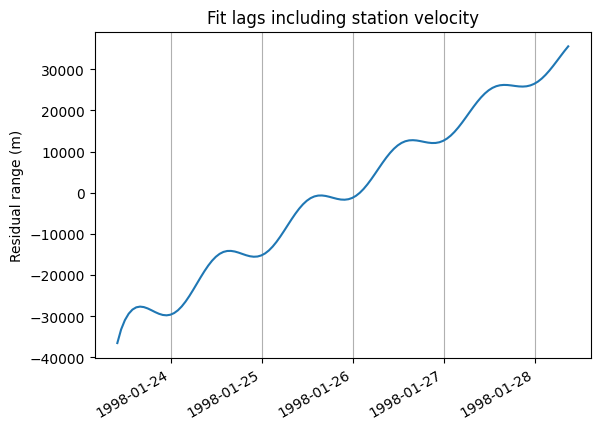

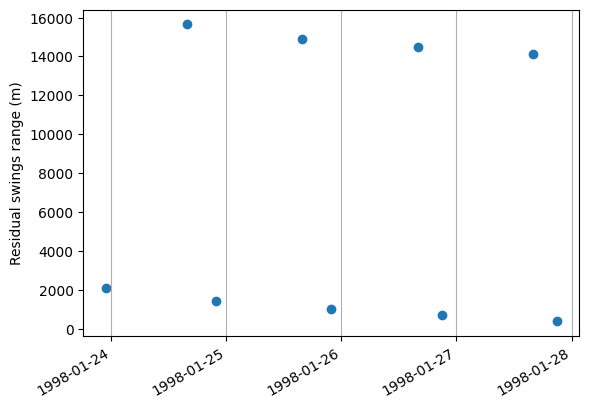

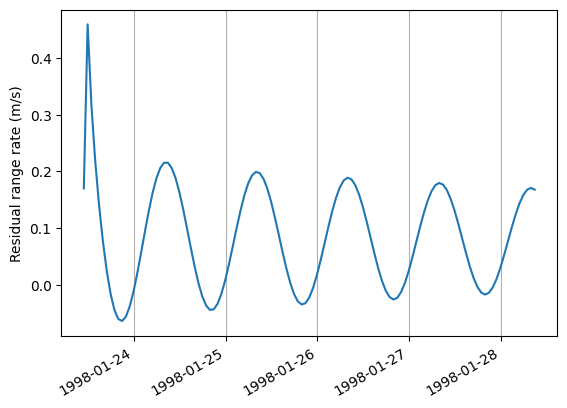

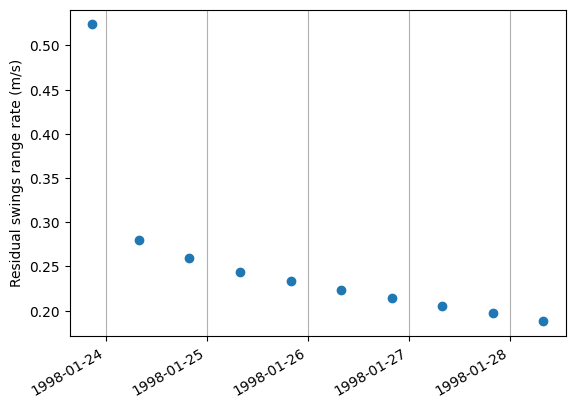

In [13]:
_, fullres_rates = fitr(near_goldstone_orbit, [dss34], epochs, rdata_ltlags_full, "Fit lags including station velocity")

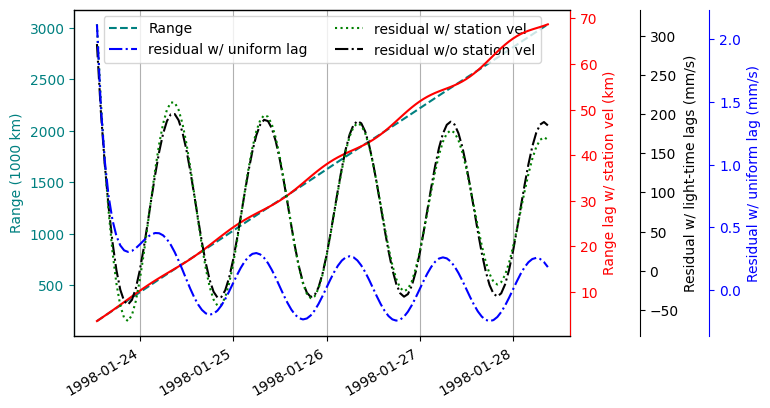

In [16]:
with visualization.time_support():
    fig, ax = plt.subplots()
    plt.xlabel('')
    plt.grid(axis='x')
    skip = 2
    skip1 = skip+1

    if tracking_period > 5*u.day:
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
    else:
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))

    ax.set_ylabel('Range (1000 km)', color = "teal")
    ax.spines['left'].set(color="teal")
    ax.tick_params(axis="y", colors="teal")

    ax2 = ax.twinx()
    ax2.set_ylabel('Range lag w/ station vel (km)', color = "red")
    ax2.spines['right'].set(color="red")
    ax2.tick_params(axis="y", colors="red")

    ax3 = ax.twinx()
    ax3.set_ylabel('Residual w/ light-time lags (mm/s)', color = "black")
    ax3.spines['right'].set_position(('outward', 50))

    ax4 = ax.twinx()
    ax4.set_ylabel('Residual w/ uniform lag (mm/s)', color = "blue")
    ax4.spines['right'].set(position=('outward', 100), color = "blue")
    ax4.tick_params(axis="y", colors="blue")


    #h1 = ax.axhline(y = 929, linestyle = "dotted", color='black', label="Earth SOI")
    #h2 = ax4.axhline(y = 384.4, linestyle = "dotted", color='black', label="Distance to moon")

    p1, = ax.plot(epochs[skip1:], [1e-3*v[0].to_value(u.km) for v in rdata_ref[skip1:]],
                  linestyle="dashed", color="teal", label="Range")
    p2, = ax2.plot(epochs[skip1:], [v.to_value(u.km) for v in rlags_full[skip1:]],
                   linestyle="-", color="red", label="lag Δv")

    p3, = ax3.plot(epochs[skip1:], [1e3*v for v in ltres_rates[skip:]],
                   linestyle='-.', color="black", label="residual w/o station vel")
    p4, = ax3.plot(epochs[skip1:], [1e3*v for v in fullres_rates[skip:]],
                   linestyle="dotted", color="green", label="residual w/ station vel")
    p5, = ax4.plot(epochs[skip1:], [1e3*v for v in const_rates[skip:]],
                   linestyle="-.", color="blue", label="residual w/ uniform lag")

    ax.legend(handles=[p1, p5, p4, p3], loc="upper center", ncol=2)
    plt.gcf().autofmt_xdate()
    plt.savefig(f'near_sim_postencounter_range-{int(tracking_period.to_value(u.day))}d.pdf', bbox_inches='tight')